In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_hist_gradient_boosting  
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from matplotlib.patches import ConnectionPatch

/home/ubuntu01/anaconda3/lib/python3.11/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [14]:
df_train = pd.read_csv("train.csv", index_col='ID')
df_test = pd.read_csv("test.csv", index_col='ID')
df_sub = pd.read_csv("sample_submission.csv", index_col='ID')

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


df_train_with_const = add_constant(df_train) 


vif_data = pd.DataFrame()
vif_data["feature"] = df_train_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(df_train_with_const.values, i) for i in range(df_train_with_const.shape[1])]

print(vif_data)

   feature            VIF
0    const  150248.069345
1      x_0       4.170073
2      x_1      28.728820
3      x_2      20.140166
4      x_3       4.601516
5      x_4      61.844731
6      x_5     108.126067
7      x_6      18.799843
8      x_7      70.729043
9      x_8     139.765997
10     x_9     141.526225
11    x_10     235.085859
12       y       2.588893


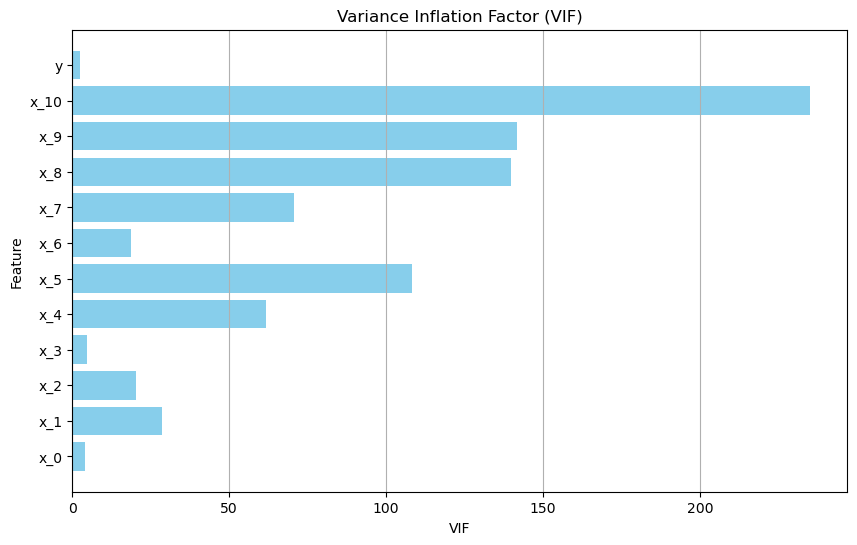

In [16]:
vif_data = vif_data[vif_data['feature'] != 'const']
plt.figure(figsize=(10, 6))
plt.barh(vif_data['feature'], vif_data['VIF'], color='skyblue')
plt.xlabel('VIF')
plt.ylabel('Feature')
plt.title('Variance Inflation Factor (VIF)')
plt.grid(axis='x')
plt.show()

In [17]:
y = df_train['y'] 
df_train = df_train.drop(['y'],axis=1)
X = df_train

In [18]:
from scipy.stats import entropy
from scipy.signal import welch,find_peaks


def count_peaks(row):
    peaks, _ = find_peaks(row)
    return len(peaks)

def spectral_entropy(row):
    _, psd = welch(row)
    return entropy(psd)

def cleaning(dataset):
    
    features = dataset.columns.tolist() 
    dataset['mean_features'] = 0.1 * dataset[features].mean(axis=1)
    dataset['std_features'] = dataset[features].std(axis=1)
    dataset['max_features'] = dataset[features].max(axis=1)
    dataset['min_features'] = dataset[features].min(axis=1)
    dataset['range_features'] = dataset['max_features'] - dataset['min_features']
    dataset['variance_features'] = dataset[features].var(axis=1)
    dataset['skewness_features'] = dataset[features].skew(axis=1)
    dataset['sum_features'] = dataset[features].sum(axis=1)

   
    mean_abs_dev = (dataset[features] - dataset[features].mean(axis=1).values.reshape(-1, 1)).abs().mean(axis=1)
    median_abs_dev = (dataset[features] - dataset[features].median(axis=1).values.reshape(-1, 1)).abs().mean(axis=1)
    range_abs_diff = (dataset[features] - dataset[features].median(axis=1).values.reshape(-1, 1)).abs().max(axis=1) - (dataset[features] - dataset[features].median(axis=1).values.reshape(-1, 1)).abs().min(axis=1)
    geometric_mean = np.exp(np.log(dataset[features].replace(0, 1)).mean(axis=1))
    harmonic_mean = len(features) / (1 / dataset[features].replace(0, 1)).sum(axis=1)
    coeff_variation = dataset['std_features'] / dataset['mean_features']

   
    quartiles = dataset[features].quantile([0.25, 0.5, 0.75], axis=1)
    dataset['first_quartile'] = quartiles.loc[0.25]
    dataset['second_quartile'] = quartiles.loc[0.5]
    dataset['third_quartile'] = quartiles.loc[0.75]

 
    kurtosis_features = dataset[features].kurtosis(axis=1)
    dataset['kurtosis_features'] = kurtosis_features

    dataset['mean_absolute_deviation'] = mean_abs_dev
    dataset['median_absolute_deviation'] = median_abs_dev
    dataset['range_abs_diff'] = range_abs_diff
    dataset['geometric_mean'] = geometric_mean
    dataset['harmonic_mean'] = harmonic_mean
    dataset['coeff_variation'] = coeff_variation
    
    #peak_features = dataset[features].apply(count_peaks, axis=1)
    #dataset['peak_frequency'] = peak_features
    
    #spectral_entropy_features = dataset[features].apply(spectral_entropy, axis=1)
    #dataset['spectral_entropy'] = spectral_entropy_features   


    #entropy_features = dataset[features].apply(entropy, axis=1)
    #dataset['entropy'] = entropy_features

    #dataset.drop(features, axis=1, inplace=True)

    return dataset

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_train_data = df_train
scaled_test_data = df_test

In [22]:
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from xgboost import XGBRegressor



xgb_params ={'n_estimators':600,
             'max_depth': 10,           
             'learning_rate': 0.06,
             'random_state':42,
             }
             

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

xgb_predictions = np.zeros(len(scaled_train_data))
xgb_true_labels = np.zeros(len(scaled_train_data))
xgb_test_predictions = np.zeros(len(scaled_test_data))

for fold, (train_idx, val_idx) in enumerate(kf.split(scaled_train_data, y)):
    X_train, X_val = scaled_train_data.iloc[train_idx], scaled_train_data.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    xgb_model = XGBRegressor(**xgb_params)

    xgb_model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_val, y_val)],
                  verbose=100)

    xgb_fold_preds = xgb_model.predict(X_val)
    xgb_fold_test_preds = xgb_model.predict(scaled_test_data)

    xgb_predictions[val_idx] = xgb_fold_preds
    xgb_true_labels[val_idx] = y_val
    xgb_test_predictions += xgb_fold_test_preds / n_splits  


overall_metric_xgb = r2_score(xgb_true_labels, xgb_predictions)
print("Overall R^2 (XGBRegressor):", overall_metric_xgb)

[0]	validation_0-rmse:2.58691	validation_1-rmse:2.57556
[100]	validation_0-rmse:1.21116	validation_1-rmse:1.64292
[200]	validation_0-rmse:1.06968	validation_1-rmse:1.65396
[300]	validation_0-rmse:0.95426	validation_1-rmse:1.66259
[400]	validation_0-rmse:0.84718	validation_1-rmse:1.67027
[500]	validation_0-rmse:0.76016	validation_1-rmse:1.67769
[599]	validation_0-rmse:0.68081	validation_1-rmse:1.68471
[0]	validation_0-rmse:2.58971	validation_1-rmse:2.56535
[100]	validation_0-rmse:1.20799	validation_1-rmse:1.65103
[200]	validation_0-rmse:1.06411	validation_1-rmse:1.66013
[300]	validation_0-rmse:0.95811	validation_1-rmse:1.67182
[400]	validation_0-rmse:0.85310	validation_1-rmse:1.68009
[500]	validation_0-rmse:0.76081	validation_1-rmse:1.68723
[599]	validation_0-rmse:0.67688	validation_1-rmse:1.69257
[0]	validation_0-rmse:2.56776	validation_1-rmse:2.65623
[100]	validation_0-rmse:1.19210	validation_1-rmse:1.79205
[200]	validation_0-rmse:1.03983	validation_1-rmse:1.80074
[300]	validation_0-r

In [23]:
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold


n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
catboost_params ={
             'random_state':42,
             'learning_rate': 0.011277016304363601, 
             'depth': 8, 
             'subsample': 0.8675506657380021, 
             'colsample_bylevel': 0.7183884158632279, 
             'min_data_in_leaf': 98
            }
catboost_predictions = np.zeros(len(scaled_train_data))
catboost_true_labels = np.zeros(len(scaled_train_data))
catboost_test_predictions = np.zeros(len(scaled_test_data))

for fold, (train_idx, val_idx) in enumerate(kf.split(scaled_train_data, y)):
    X_train, X_val = scaled_train_data.iloc[train_idx], scaled_train_data.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    catboost_model = CatBoostRegressor(**catboost_params)

    catboost_model.fit(X_train, y_train,
                       eval_set=(X_val, y_val),
                       early_stopping_rounds=10)

    catboost_fold_preds = catboost_model.predict(X_val)
    
    catboost_fold_test_preds = catboost_model.predict(scaled_test_data)

    catboost_predictions[val_idx] = catboost_fold_preds
    catboost_true_labels[val_idx] = y_val
    catboost_test_predictions += catboost_fold_test_preds / n_splits 

overall_metric_catboost = r2_score(catboost_true_labels, catboost_predictions)
print("Overall R^2 (CatBoostRegressor):", overall_metric_catboost)

0:	learn: 2.6744649	test: 2.6566668	best: 2.6566668 (0)	total: 63.5ms	remaining: 1m 3s
1:	learn: 2.6568461	test: 2.6384104	best: 2.6384104 (1)	total: 69.2ms	remaining: 34.5s
2:	learn: 2.6395076	test: 2.6203464	best: 2.6203464 (2)	total: 73.9ms	remaining: 24.5s
3:	learn: 2.6224028	test: 2.6024856	best: 2.6024856 (3)	total: 80.2ms	remaining: 20s
4:	learn: 2.6056145	test: 2.5848778	best: 2.5848778 (4)	total: 94.3ms	remaining: 18.8s
5:	learn: 2.5891787	test: 2.5678255	best: 2.5678255 (5)	total: 100ms	remaining: 16.6s
6:	learn: 2.5730376	test: 2.5509671	best: 2.5509671 (6)	total: 114ms	remaining: 16.2s
7:	learn: 2.5570325	test: 2.5343798	best: 2.5343798 (7)	total: 119ms	remaining: 14.7s
8:	learn: 2.5413101	test: 2.5181158	best: 2.5181158 (8)	total: 135ms	remaining: 14.9s
9:	learn: 2.5258733	test: 2.5020041	best: 2.5020041 (9)	total: 140ms	remaining: 13.9s
10:	learn: 2.5107863	test: 2.4861692	best: 2.4861692 (10)	total: 146ms	remaining: 13.1s
11:	learn: 2.4957200	test: 2.4704296	best: 2.4704

In [27]:
from lightgbm import LGBMRegressor

n_splits =5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Parametere derived from here https://www.kaggle.com/code/thiagomantuani/ps4e5-flood-prediction-get-started
# One can get this using optuna, gris, random or baysein technique as well which will take time
#https://www.kaggle.com/code/harshitstark/regression-with-a-flood-prediction-dataset/notebook

lgb_params = {
    'boosting_type': 'gbdt', 
    'n_estimators':1500, 
    'learning_rate' :  0.012,    
    'num_leaves' : 250, 
    'subsample_for_bin': 165700, 
    'min_child_samples': 114, 
    'reg_alpha': 2.075e-06, 
    'reg_lambda': 3.839e-07, 
    'colsample_bytree': 0.9634,
    'subsample': 0.9592, 
    'max_depth': 10,
    'random_state':0,
    'verbosity':-1}

lgbm_predictions = np.zeros(len(scaled_train_data))
lgbm_true_labels = np.zeros(len(scaled_train_data))
lgbm_test_predictions = np.zeros(len(scaled_test_data))

for fold, (train_idx, val_idx) in enumerate(kf.split(scaled_train_data, y)):
    X_train, X_val = scaled_train_data.iloc[train_idx], scaled_train_data.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    lgbm_model = LGBMRegressor(**lgb_params)

    lgbm_model.fit(X_train, y_train,
                   eval_set=[(X_val, y_val)],
                   eval_metric='rmse')

    lgbm_fold_preds = lgbm_model.predict(X_val)
    lgbm_fold_test_preds = lgbm_model.predict(scaled_test_data)

    lgbm_predictions[val_idx] = lgbm_fold_preds
    lgbm_true_labels[val_idx] = y_val
    lgbm_test_predictions += lgbm_fold_test_preds / n_splits

overall_metric_lgbm = r2_score(lgbm_true_labels, lgbm_predictions)
print("Overall R^2 (LGBMRegressor):", overall_metric_lgbm)

Overall R^2 (LGBMRegressor): 0.6061653122002939


In [28]:
df_sub['y'] = lgbm_test_predictions *0.7 + (catboost_test_predictions*0.0 + xgb_test_predictions*0.3)

In [29]:
df_sub.head()

,y
ID,
TEST_0000,83.338628
TEST_0001,82.033289
TEST_0002,90.914363
TEST_0003,91.213839
TEST_0004,82.094884


In [31]:
df_sub.to_csv('flood.csv')